In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # Use tqdm.notebook for Jupyter
import time

# --- Configuration ---
MEASUREMENTS_FILE = 'measurements_v9.csv'
PARAMS_FILE = 'mosfet_params_v9.csv'
VDS_SATURATION = 5.0  # Vds value for saturation region data
VGS_LINEAR_THRESHOLD_LOW = 1.5 # Lower Vgs bound for linear fitting
VGS_LINEAR_THRESHOLD_HIGH = 4.0 # Upper Vgs bound for linear fitting

In [4]:
def load_data(measurements_file, params_file):
    """Load the measurement and parameter CSV files into DataFrames."""
    df_meas = pd.DataFrame()
    df_params = pd.DataFrame()
    try:
        df_meas = pd.read_csv(measurements_file)
        print(f"Loaded {measurements_file}")
    except FileNotFoundError:
        print(f"Error: {measurements_file} not found.")

    try:
        df_params = pd.read_csv(params_file)
        print(f"Loaded {params_file}")
    except FileNotFoundError:
        print(f"Error: {params_file} not found.")

    # Find common MOSFET IDs
    if not df_meas.empty and not df_params.empty:
        common_ids = np.intersect1d(df_meas['MOSFET_ID'].unique(), df_params['MOSFET_ID'].unique())
        print(f"\nFound {len(common_ids)} MOSFET IDs common to both files.")
        # Filter DataFrames to only include common IDs for efficiency
        df_meas = df_meas[df_meas['MOSFET_ID'].isin(common_ids)].copy()
        df_params = df_params[df_params['MOSFET_ID'].isin(common_ids)].copy()
        print(f"DataFrames filtered to common IDs.")
    else:
        common_ids = []
        print("\nCould not find common IDs due to missing files.")


    return df_meas, df_params, common_ids

# Load data once
df_meas, df_params, common_ids = load_data(MEASUREMENTS_FILE, PARAMS_FILE)

Loaded measurements_v9.csv
Loaded mosfet_params_v9.csv

Found 50000 MOSFET IDs common to both files.
DataFrames filtered to common IDs.


In [5]:
def process_mosfets_kp(df_meas, df_params, common_ids, num_devices, vds_saturation, vgs_low, vgs_high):
    """
    Process MOSFET data to calculate Vth and KP for a specified number of devices,
    accounting for channel length modulation (LAMBDA).
    Returns a DataFrame with results.
    """
    results = []
    processed_ids = []

    if not df_meas.empty and not df_params.empty and len(common_ids) > 0:

        if num_devices is not None and num_devices < len(common_ids):
            ids_to_process = common_ids[:num_devices]
            print(f"\nProcessing first {num_devices} of {len(common_ids)} common MOSFETs...")
        else:
            ids_to_process = common_ids
            print(f"\nProcessing all {len(common_ids)} common MOSFETs...")

        start_time = time.time()

        for mosfet_id in tqdm(ids_to_process, desc="Calculating Vth & KP"):
            # --- Initialization for this MOSFET ---
            vth_extrapolated = np.nan
            kp_extracted = np.nan
            kp_actual = np.nan
            vth_actual = np.nan
            w_val = np.nan
            l_val = np.nan
            lambda_val = np.nan # Added LAMBDA
            kp_percent_error = np.nan

            # --- Get Data for Current MOSFET ---
            df_single_mosfet = df_meas[df_meas['MOSFET_ID'] == mosfet_id]
            actual_params_df = df_params[df_params['MOSFET_ID'] == mosfet_id]

            if actual_params_df.empty:
                continue

            # --- Saturation Data ---
            df_sat = df_single_mosfet[np.isclose(df_single_mosfet['VDS'], vds_saturation)].copy()
            if df_sat.empty:
                continue

            # --- Sqrt(Id) ---
            df_sat['SQRT_ID'] = np.sqrt(df_sat['ID'].clip(lower=1e-15))

            # --- Linear Region Data ---
            df_linear_region = df_sat[
                (df_sat['VGS'] > vgs_low) &
                (df_sat['VGS'] <= vgs_high) &
                (df_sat['ID'] > 1e-9)
            ]

            # --- Linear Fit ---
            if len(df_linear_region) >= 2:
                vgs_linear = df_linear_region['VGS']
                sqrt_id_linear = df_linear_region['SQRT_ID']

                try:
                    slope, intercept = np.polyfit(vgs_linear, sqrt_id_linear, 1)

                    if slope > 1e-9:
                        # --- Calculate Vth ---
                        vth_extrapolated = -intercept / slope

                        # --- Retrieve Actual Parameters Needed for KP ---
                        w_val = actual_params_df['W'].iloc[0]
                        l_val = actual_params_df['L'].iloc[0]
                        lambda_val = actual_params_df['LAMBDA'].iloc[0] # Get LAMBDA
                        W_div_L = w_val / l_val if l_val != 0 else np.nan

                        # --- Calculate KP (Corrected for LAMBDA) ---
                        # Measured Slope^2 = (KP_actual * W / (2*L)) * (1 + LAMBDA * Vds)
                        # KP_actual * (W/L) = (2 * Slope^2) / (1 + LAMBDA * Vds)
                        lambda_correction_factor = (1 + lambda_val * vds_saturation)

                        if lambda_correction_factor > 1e-9: # Avoid division by zero/small number
                             kp_times_W_div_L = (2 * slope**2) / lambda_correction_factor
                        else:
                             kp_times_W_div_L = np.nan # Cannot correct if factor is invalid

                        if W_div_L != 0 and not np.isnan(W_div_L) and not np.isnan(kp_times_W_div_L):
                             kp_extracted = kp_times_W_div_L / W_div_L
                        else:
                             kp_extracted = np.nan

                    # else: Vth/KP remain NaN if slope is zero or negative

                except (np.linalg.LinAlgError, ValueError):
                    pass # Silently skip on fit failure

            # --- Get Actual Values & Calculate Error ---
            vth_actual = actual_params_df['VTO'].iloc[0]
            kp_actual = actual_params_df['KP'].iloc[0]

            if not np.isnan(kp_extracted) and not np.isnan(kp_actual):
                if kp_actual != 0:
                    kp_percent_error = abs((kp_extracted - kp_actual) / kp_actual) * 100
                elif kp_extracted == 0:
                     kp_percent_error = 0.0
                else:
                     kp_percent_error = float('inf')

            # --- Store Results ---
            results.append({
                'MOSFET_ID': mosfet_id,
                'Actual_KP': kp_actual,
                'Extrapolated_KP': kp_extracted,
                'KP_Percentage_Error': kp_percent_error,
                'Actual_Vth': vth_actual,
                'Extrapolated_Vth': vth_extrapolated,
                'W': w_val,
                'L': l_val,
                'LAMBDA': lambda_val # Store Lambda used
            })
            processed_ids.append(mosfet_id)

        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"\nTime taken to process {len(processed_ids)} MOSFETs: {elapsed_time:.2f} seconds")

        return pd.DataFrame(results)

    else:
        print("\nCannot proceed. Ensure measurement and parameter data are loaded and common IDs exist.")
        return pd.DataFrame()

In [6]:
def display_kp_results(df_kp_results):
    """Display KP and Vth results and analyze percentage errors."""
    if not df_kp_results.empty:
        print("\n--- KP and Vth Calculation and Comparison Results ---")
        # Display first few and last few rows
        with pd.option_context('display.max_rows', 10, 'display.float_format', '{:,.4e}'.format):
            print(df_kp_results)

        # Analyze KP Percentage Error
        valid_kp_errors = df_kp_results['KP_Percentage_Error'].dropna().replace([np.inf, -np.inf], np.nan).dropna()
        
        # Calculate Vth Percentage Error
        df_kp_results['Vth_Percentage_Error'] = abs((df_kp_results['Extrapolated_Vth'] - df_kp_results['Actual_Vth']) / 
                                                   df_kp_results['Actual_Vth'].replace(0, np.nan)) * 100
        valid_vth_errors = df_kp_results['Vth_Percentage_Error'].dropna().replace([np.inf, -np.inf], np.nan).dropna()

        # KP Error Summary
        if not valid_kp_errors.empty:
            print("\n--- Summary Statistics for KP Percentage Error ---")
            print(f"Mean Error:        {valid_kp_errors.mean():.2f}%")
            print(f"Median Error:      {valid_kp_errors.median():.2f}%")
            print(f"Standard Deviation:{valid_kp_errors.std():.2f}%")
            print(f"Min Error:         {valid_kp_errors.min():.2f}%")
            print(f"Max Error:         {valid_kp_errors.max():.2f}%")
            num_valid_kp = len(valid_kp_errors)
            num_total = len(df_kp_results)
            num_nan_inf_kp = num_total - num_valid_kp
            print(f"MOSFETs Analyzed:  {num_total}")
            print(f"Valid KP Errors:   {num_valid_kp} ({num_nan_inf_kp} NaN/Inf errors excluded)")

            # Plot histogram of KP errors
            plt.figure(figsize=(10, 5))
            plt.hist(valid_kp_errors, bins=50, edgecolor='black', range=(0, valid_kp_errors.quantile(0.99)))
            plt.title('Distribution of Percentage Error in KP Extrapolation')
            plt.xlabel('KP Percentage Error (%)')
            plt.ylabel('Number of MOSFETs')
            plt.grid(axis='y', alpha=0.75)
            plt.show()
        else:
            print("\nNo valid KP percentage errors calculated to summarize.")

        # Vth Error Summary
        if not valid_vth_errors.empty:
            print("\n--- Summary Statistics for Vth Percentage Error ---")
            print(f"Mean Error:        {valid_vth_errors.mean():.2f}%")
            print(f"Median Error:      {valid_vth_errors.median():.2f}%")
            print(f"Standard Deviation:{valid_vth_errors.std():.2f}%")
            print(f"Min Error:         {valid_vth_errors.min():.2f}%")
            print(f"Max Error:         {valid_vth_errors.max():.2f}%")
            num_valid_vth = len(valid_vth_errors)
            num_nan_inf_vth = num_total - num_valid_vth
            print(f"Valid Vth Errors:  {num_valid_vth} ({num_nan_inf_vth} NaN/Inf errors excluded)")

            # Plot histogram of Vth errors
            plt.figure(figsize=(10, 5))
            plt.hist(valid_vth_errors, bins=50, edgecolor='black', range=(0, valid_vth_errors.quantile(0.99)))
            plt.title('Distribution of Percentage Error in Vth Extrapolation')
            plt.xlabel('Vth Percentage Error (%)')
            plt.ylabel('Number of MOSFETs')
            plt.grid(axis='y', alpha=0.75)
            plt.show()
        else:
            print("\nNo valid Vth percentage errors calculated to summarize.")
    else:
        print("\nNo results to display.")


Processing first 10000 of 50000 common MOSFETs...


Calculating Vth & KP:   0%|          | 0/10000 [00:00<?, ?it/s]


Time taken to process 10000 MOSFETs: 268.77 seconds

--- KP and Vth Calculation and Comparison Results ---
      MOSFET_ID  Actual_KP  Extrapolated_KP  KP_Percentage_Error  Actual_Vth  \
0             1 1.2624e-04       1.2624e-04           1.6077e-04  1.1424e+00   
1             2 1.3093e-04       1.3093e-04           6.2943e-04  7.9374e-01   
2             3 1.8241e-04       1.8241e-04           3.8824e-04  1.1708e+00   
3             4 4.0765e-04       4.0764e-04           4.0095e-04  7.7079e-01   
4             5 7.8507e-05       7.8507e-05           1.6703e-04  1.0455e+00   
...         ...        ...              ...                  ...         ...   
9995       9996 1.4668e-04       1.4668e-04           1.1030e-03  1.0988e+00   
9996       9997 1.2545e-04       1.2545e-04           4.4222e-05  7.6352e-01   
9997       9998 2.1349e-04       2.1349e-04           5.9373e-04  6.7658e-01   
9998       9999 3.2737e-04       3.2736e-04           1.5669e-03  7.5144e-01   
9999      10

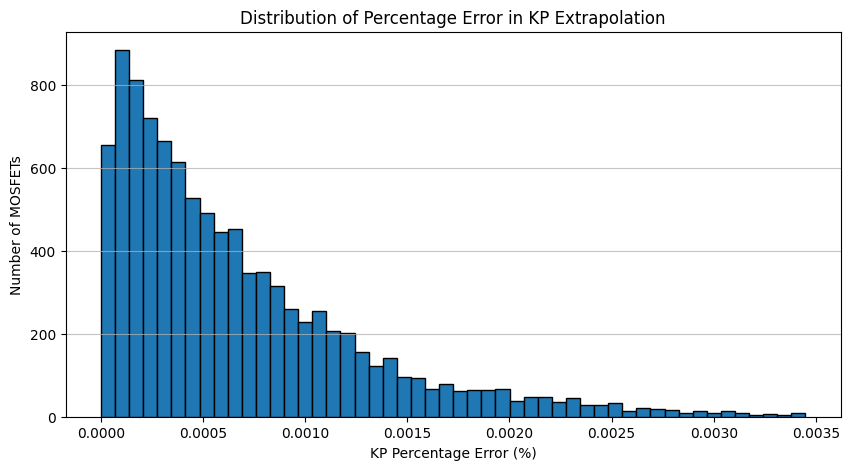


--- Summary Statistics for Vth Percentage Error ---
Mean Error:        0.00%
Median Error:      0.00%
Standard Deviation:0.00%
Min Error:         0.00%
Max Error:         0.01%
Valid Vth Errors:  10000 (0 NaN/Inf errors excluded)


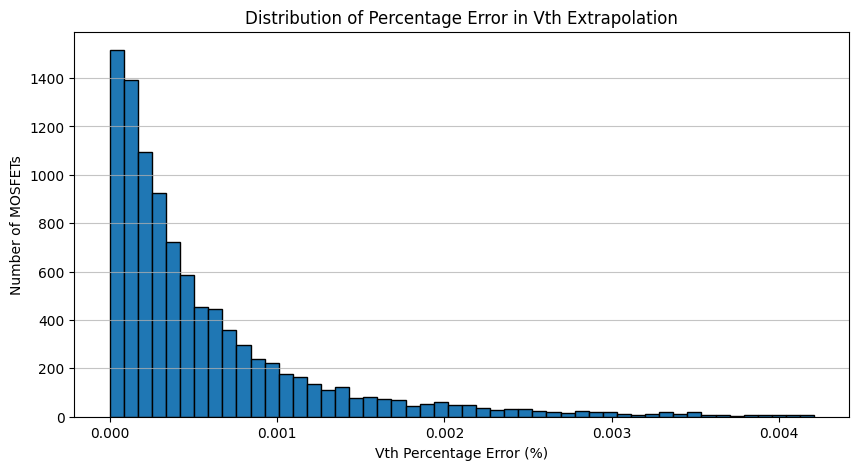

In [7]:
# --- Main Execution ---

# Define how many devices to process (set to None to process all common IDs)
NUM_DEVICES_TO_PROCESS = 10000  # <<< MODIFY THIS VALUE OR SET TO None >>>

# Ensure data is loaded before processing
if 'df_meas' in locals() and 'df_params' in locals() and not df_meas.empty and not df_params.empty:
    # Process the MOSFETs
    df_kp_results = process_mosfets_kp(
        df_meas,
        df_params,
        common_ids, # Pass the list of common IDs
        NUM_DEVICES_TO_PROCESS,
        VDS_SATURATION,
        VGS_LINEAR_THRESHOLD_LOW,
        VGS_LINEAR_THRESHOLD_HIGH
    )

    # Display the results
    display_kp_results(df_kp_results)
else:
    print("Please ensure data is loaded successfully in Block 2 before running this block.")